# Atari Reinforcement Learning - Breakout Game

In [1]:
import numpy as np
import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
from random import random
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import os
import time
import tkinter as tk
from tkinter import messagebox
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch, torchvision, cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

#initialize for random seeds/states
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
rng = np.random.default_rng(12345)
np.random.seed(42)
tf.random.set_seed(42)

device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')

print(device)

cpu


# Import Arcade Learning Environment 

Let's choose a classic game and explore the environment variables.

In [2]:
# put in the 0 action 
import gym
env = gym.make('Breakout-v0')
env.reset()
observation_image, reward, done, info = env.step(0)
print('observation image shape: {}'.format(observation_image.shape))
print('observation image max: {}'.format(np.max(observation_image)))
print('reward: {}'.format(reward))
print('done: {}'.format(done))
print('info: {}'.format(info))

observation image shape: (210, 160, 3)
observation image max: 200
reward: 0.0
done: False
info: {'lives': 5, 'episode_frame_number': 3, 'frame_number': 3}


A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


In [3]:
env.action_space

Discrete(4)

In [4]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [5]:
env.observation_space.shape

(210, 160, 3)

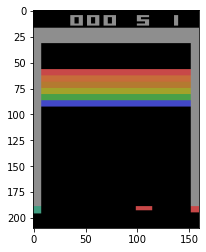

In [6]:
plt.imshow(observation_image)
plt.show()

In [7]:
observation_image[30:35,100,:]

array([[142, 142, 142],
       [142, 142, 142],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0]], dtype=uint8)

In [8]:
observation_image[190:200,100,:]

array([[200,  72,  72],
       [200,  72,  72],
       [200,  72,  72],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0]], dtype=uint8)

### Crop to exclude irrelevant parts 

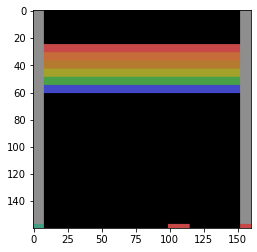

In [9]:
plt.imshow(observation_image[32:192])
plt.show()

In [10]:
R = observation_image[32:192,:,0]
G = observation_image[32:192,:,1]
B = observation_image[32:192,:,2]
grey = (0.299*R+0.587*G+0.114*B)/255

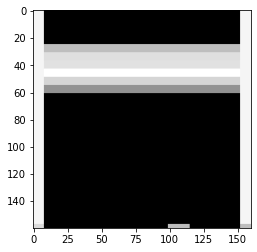

In [11]:
plt.imshow(grey, cmap='gray')
plt.show()

In [12]:
R.shape

(160, 160)

In [13]:
#Reference: Lab7 and https://docs.ray.io/en/latest/rllib/rllib-models.html
# https://docs.ray.io/en/master/rllib-algorithms.html#deep-q-networks-dqn-rainbow-parametric-dqn
import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print

config = dqn.DEFAULT_CONFIG.copy()

#config for framework and ALE game
config["framework"] = "torch"
config["env"] = 'Breakout-v0'
#config['num_workers']=4  #not allowed for free google Colab
if device != torch.device('cpu'):
    config['num_gpus'] = 1

#rainbow DQN config
config["dueling"] = True
config["double_q"] = True
config["n_step"] = 4
config["prioritized_replay"] = True
config["num_atoms"] = 51
config["v_min"] = -1
config["v_max"] = 1
config["noisy"] = True

#model config  #conv_filters none means let it try
config["model"] = { "framestack":True, "dim":84, "conv_filters":None, "conv_activation":"relu", "post_fcnet_activation":"relu", "grayscale":True,}   

trainer = dqn.DQNTrainer(config=config)

# Can optionally call trainer.restore(path) to load a checkpoint.

avg_rewards = []

for i in range(200):
    # Perform one iteration of training the policy
    result = trainer.train()
    #print(pretty_print(result))
    print(result['episode_reward_mean'])
    avg_rewards.append(result['episode_reward_mean'])

    if i % 10 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)

/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/rllib/agents/dqn/dqn_torch_model.py:151: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  z = torch.range(
/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/rllib/agents/dqn/dqn_torch_policy.py:50: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  z = torch.range(
Install gputil for GPU system monitoring.
2022-04-11 01:22:28,772	WARNING replay_buffer.py:39 -- Estimated max memory usage for replay buffer is 2.82465 GB (50000.0 batches of size 1, 56493 bytes each), available system memory is 8.589934592 GB
2022-04-11 01:22:32,351	WARNING deprecation.py:45 -

0.75
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_01-22-28ltzsc_uk/checkpoint_000001/checkpoint-1
1.125
1.0769230769230769
1.411764705882353
1.4761904761904763
1.56
1.4827586206896552
1.5454545454545454
1.4736842105263157
1.4186046511627908
1.4680851063829787
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_01-22-28ltzsc_uk/checkpoint_000011/checkpoint-11
1.5294117647058822
1.5272727272727273
1.5254237288135593
1.5396825396825398
1.5294117647058822
1.5694444444444444
1.5866666666666667
1.6075949367088607
1.6265060240963856
1.6781609195402298
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_01-22-28ltzsc_uk/checkpoint_000021/checkpoint-21
1.7222222222222223
1.7052631578947368
1.7346938775510203
1.75
1.77
1.77
1.85
1.84
1.85
1.86
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_01-22-28ltzsc_uk/checkpoint_000031/checkpoint-31
1.9
1.93
1.96
2.

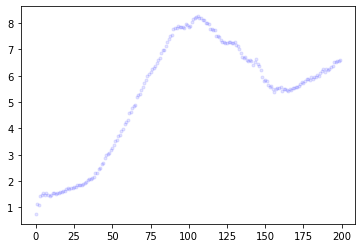

In [14]:
plt.plot(avg_rewards, 'b.', alpha=.1)

# Ablation Study

We may build helper functions for ablation study by wrapping the training part and make use of config and result dictionary.

In [15]:
config_default = dqn.DEFAULT_CONFIG.copy()

In [16]:
print(config_default)

{'num_workers': 0, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 4, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0005, 'train_batch_size': 32, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, '_disable_action_flattening': False, 'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': True, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_ac

In [17]:
print(result)

{'episode_reward_max': 17.0, 'episode_reward_min': 0.0, 'episode_reward_mean': 6.61, 'episode_len_mean': 502.77, 'episode_media': {}, 'episodes_this_iter': 2, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [1.0, 2.0, 4.0, 5.0, 10.0, 6.0, 4.0, 2.0, 3.0, 4.0, 4.0, 5.0, 9.0, 6.0, 14.0, 3.0, 4.0, 6.0, 4.0, 9.0, 9.0, 2.0, 5.0, 3.0, 9.0, 3.0, 7.0, 8.0, 3.0, 9.0, 7.0, 4.0, 8.0, 6.0, 5.0, 17.0, 7.0, 3.0, 8.0, 9.0, 7.0, 7.0, 6.0, 9.0, 7.0, 12.0, 7.0, 7.0, 9.0, 8.0, 6.0, 9.0, 7.0, 6.0, 8.0, 5.0, 3.0, 2.0, 8.0, 12.0, 9.0, 10.0, 7.0, 8.0, 9.0, 2.0, 7.0, 10.0, 7.0, 4.0, 6.0, 4.0, 9.0, 7.0, 8.0, 14.0, 8.0, 8.0, 6.0, 8.0, 7.0, 2.0, 0.0, 10.0, 4.0, 5.0, 11.0, 7.0, 7.0, 11.0, 8.0, 7.0, 1.0, 6.0, 5.0, 10.0, 6.0, 8.0, 6.0, 7.0], 'episode_lengths': [249, 292, 389, 446, 660, 455, 388, 248, 348, 339, 424, 409, 538, 551, 753, 306, 440, 470, 330, 681, 621, 274, 466, 352, 624, 345, 540, 649, 331, 648, 577, 372, 609, 465, 447, 9

In [18]:
print(pretty_print(result))

agent_timesteps_total: 200000
custom_metrics: {}
date: 2022-04-11_02-56-31
done: false
episode_len_mean: 502.77
episode_media: {}
episode_reward_max: 17.0
episode_reward_mean: 6.61
episode_reward_min: 0.0
episodes_this_iter: 2
episodes_total: 486
experiment_id: ef31f83d5ba04f3fb0091ff998345d73
hostname: Suens-MBP
info:
  last_target_update_ts: 199576
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_lr: 0.0005
        grad_gnorm: 0.4718281626701355
      mean_td_error: 1.9447383880615234
      model: {}
      td_error:
      - 2.2011046409606934
      - 2.091184616088867
      - 2.1005208492279053
      - 2.1070680618286133
      - 1.0533493757247925
      - 2.270803928375244
      - 2.2423269748687744
      - 2.0599541664123535
      - 2.281139612197876
      - 2.4055328369140625
      - 2.0444376468658447
      - 1.9786161184310913
      - 2.26517391204834
      - 2.066484212875366
      - 2.136904001235962
      -

In [19]:
def trainDQN(config, iteration=200):
    trainer = dqn.DQNTrainer(config=config)

    # Can optionally call trainer.restore(path) to load a checkpoint.

    avg_rewards = []

    for i in range(200):
        # Perform one iteration of training the policy
        result = trainer.train()
        #print(pretty_print(result))
        print(result['episode_reward_mean'])
        avg_rewards.append(result['episode_reward_mean'])

        if i % 10 == 0:
            checkpoint = trainer.save()
            print("checkpoint saved at", checkpoint)
    
    return avg_rewards, checkpoint

### 1. Remove dueling 

The dueling DQN algorithm splits the Q-values into sum of two different parts, the value function V(s) and the advantage function A(s, a). 

Let's see the impact after removing this.

Reference: https://markelsanz14.medium.com/introduction-to-reinforcement-learning-part-4-double-dqn-and-dueling-dqn-b349c9a61ea1

In [20]:
config1 = config.copy()
config1["dueling"] = False
avg_rewards1, checkpoint1 = trainDQN(config1)

Install gputil for GPU system monitoring.


0.6
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_02-56-31n50xulvq/checkpoint_000001/checkpoint-1
0.5
0.7333333333333333
0.8421052631578947
0.75
0.7241379310344828
0.8181818181818182
1.0
0.9761904761904762
1.0434782608695652
1.14
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_02-56-31n50xulvq/checkpoint_000011/checkpoint-11
1.1481481481481481
1.152542372881356
1.1428571428571428
1.161764705882353
1.0945945945945945
1.1282051282051282
1.170731707317073
1.197674418604651
1.2359550561797752
1.2446808510638299
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_02-56-31n50xulvq/checkpoint_000021/checkpoint-21
1.2653061224489797
1.26
1.32
1.3
1.3
1.27
1.32
1.34
1.31
1.31
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_02-56-31n50xulvq/checkpoint_000031/checkpoint-31
1.35
1.3
1.29
1.27
1.28
1.29
1.36
1.39
1.42
1.41
checkpoint saved at /Users/suenc

### 2. Remove double DQN

The Double DQN solves the problem of overestimation of Q-value by using 2 Q-networks to de-couple the action selection and evaluation. Randomly or alternatively pick one Q-network for action selection, then another Q-network is used for evaluation.

Let's see the impact after removing this.

Reference: https://markelsanz14.medium.com/introduction-to-reinforcement-learning-part-4-double-dqn-and-dueling-dqn-b349c9a61ea1

In [21]:
config2 = config.copy()
config2["double_q"] = False
avg_rewards2, checkpoint2 = trainDQN(config2)

Install gputil for GPU system monitoring.


1.25
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_04-25-15ig077_y0/checkpoint_000001/checkpoint-1
0.8888888888888888
0.8
0.9473684210526315
1.0434782608695652
1.1923076923076923
1.3333333333333333
1.2
1.2820512820512822
1.3095238095238095
1.3695652173913044
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_04-25-15ig077_y0/checkpoint_000011/checkpoint-11
1.34
1.4444444444444444
1.5087719298245614
1.6
1.671875
1.7014925373134329
1.6619718309859155
1.68
1.6962025316455696
1.6746987951807228
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_04-25-15ig077_y0/checkpoint_000021/checkpoint-21
1.6744186046511629
1.6853932584269662
1.6595744680851063
1.6122448979591837
1.63
1.65
1.63
1.66
1.63
1.57
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_04-25-15ig077_y0/checkpoint_000031/checkpoint-31
1.55
1.59
1.56
1.57
1.6
1.64
1.56
1.54
1.49
1.45
checkpoi

### 3. Remove N-step DQN

N-step DQN is simialr to DQN except that N-steps are sampled instead of using one step only for an update.

𝐺𝑡:𝑡+𝑛=𝛾𝑛max𝑎′[𝑄(𝑆𝑡+𝑛,𝑎′)]+∑𝑘=0𝑛−1𝛾𝑘𝑅𝑡+𝑘+1

Let's see the impact after removing this.

Ref: https://datascience.stackexchange.com/questions/46245/off-policy-n-step-learning-with-dqn

In [22]:
config3 = config.copy()
config3["n_step"] = 1
avg_rewards3, checkpoint3 = trainDQN(config3)

Install gputil for GPU system monitoring.


2.3333333333333335
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_05-47-22gdykcisq/checkpoint_000001/checkpoint-1
2.3333333333333335
2.6
2.6923076923076925
2.5
2.3636363636363638
2.185185185185185
2.3
2.264705882352941
2.1025641025641026
2.119047619047619
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_05-47-22gdykcisq/checkpoint_000011/checkpoint-11
1.9583333333333333
1.830188679245283
1.8245614035087718
1.7741935483870968
1.8181818181818181
1.7746478873239437
1.7763157894736843
1.7160493827160495
1.632183908045977
1.6195652173913044
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_05-47-22gdykcisq/checkpoint_000021/checkpoint-21
1.6421052631578947
1.62
1.53
1.54
1.51
1.47
1.44
1.39
1.32
1.27
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_05-47-22gdykcisq/checkpoint_000031/checkpoint-31
1.25
1.29
1.3
1.38
1.41
1.43
1.48
1.43
1.49
1.48
che

### 4. Remove Prioritized Replay

Initial DQN samples experience replay randomly, while prioritized replay samples according to priority (and avoid zero probability of sampling low-priority replays) with importance-sampling (IS) weights. Key parameters to tune prioritization: alpha and beta.

Let's see the impact after removing this.

Ref: https://paperswithcode.com/method/prioritized-experience-replay


In [23]:
config4 = config.copy()
config4["prioritized_replay"] = False
avg_rewards4, checkpoint4 = trainDQN(config4)

Install gputil for GPU system monitoring.


1.5
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_07-21-07prfi_8z2/checkpoint_000001/checkpoint-1
1.25
1.3076923076923077
1.1666666666666667
1.173913043478261
1.1481481481481481
1.1875
1.0789473684210527
1.0
1.0425531914893618
1.0384615384615385
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_07-21-07prfi_8z2/checkpoint_000011/checkpoint-11
1.1272727272727272
1.1333333333333333
1.1875
1.2388059701492538
1.2535211267605635
1.3333333333333333
1.358974358974359
1.3132530120481927
1.3488372093023255
1.3444444444444446
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_07-21-07prfi_8z2/checkpoint_000021/checkpoint-21
1.3936170212765957
1.4639175257731958
1.48
1.5
1.54
1.59
1.65
1.71
1.78
1.81
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_07-21-07prfi_8z2/checkpoint_000031/checkpoint-31
1.86
1.89
2.0
2.01
2.1
2.05
2.08
2.09
2.16
2.15
checkpoint 

### 5. Remove Categorical DQN

The main objective of Categorical Deep Q-Networks is to learn the distribution of Q-values as unlike to other variants of Deep Q-Networks where the goal is is to approximate the expectations of the Q-values as closely as possible. In complicated environments, the Q-values can be stochastic and in that case, simply learning the expectation of Q-values will not be able to capture all the information needed (for eg. variance of the distribution) to make an optimal decision.

Let's see the impact after removing this.

Ref: https://genrl.readthedocs.io/en/latest/usage/tutorials/Deep/Categorical_DQN.html

In [24]:
config5 = config.copy()
config5["num_atoms"] = 1
avg_rewards5, checkpoint5 = trainDQN(config5)

Install gputil for GPU system monitoring.


1.0
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_08-53-162z5st01w/checkpoint_000001/checkpoint-1
1.0
1.2307692307692308
1.375
1.5789473684210527
1.7391304347826086
1.6296296296296295
1.7419354838709677
1.8285714285714285
1.868421052631579
1.8095238095238095
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_08-53-162z5st01w/checkpoint_000011/checkpoint-11
1.8888888888888888
1.9591836734693877
1.9807692307692308
1.9821428571428572
1.9166666666666667
1.9375
1.9705882352941178
1.9855072463768115
2.0
2.013333333333333
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_08-53-162z5st01w/checkpoint_000021/checkpoint-21
1.9873417721518987
1.9879518072289157
1.9770114942528736
1.989010989010989
1.9684210526315788
1.9595959595959596
1.96
2.0
2.0
2.03
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_08-53-162z5st01w/checkpoint_000031/checkpoint-31
2.01
1.

### 6. Remove noisy network

It utilises noisy final linear layers of the neural network for exploration instead of epsilon-greedy exploration as in the original DQN formulation. i.e. replaces standard -greedy exploration with noisy linear layers that include a noisy stream.

Let's see the impact after removing this.

Ref: https://paperswithcode.com/method/noisynet-dqn

In [25]:
config6 = config.copy()
config6["noisy"] = False
avg_rewards6, checkpoint6 = trainDQN(config6)

Install gputil for GPU system monitoring.


1.5
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_10-23-32qfbytyhc/checkpoint_000001/checkpoint-1
0.8888888888888888
0.8571428571428571
0.8421052631578947
0.8333333333333334
0.7666666666666667
0.8529411764705882
0.9736842105263158
1.119047619047619
1.0425531914893618
1.1372549019607843
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_10-23-32qfbytyhc/checkpoint_000011/checkpoint-11
1.1851851851851851
1.293103448275862
1.360655737704918
1.484375
1.5522388059701493
1.6142857142857143
1.6891891891891893
1.7532467532467533
1.8125
1.819277108433735
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_10-23-32qfbytyhc/checkpoint_000021/checkpoint-21
1.9069767441860466
2.0112359550561796
2.065934065934066
2.1382978723404253
2.1979166666666665
2.242424242424242
2.3
2.38
2.48
2.59
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_10-23-32qfbytyhc/checkpoi

### 7. Remove every thing - Back to vanilla DQN

In [26]:
config7 = config.copy()
config7["dueling"] = False
config7["double_q"] = False
config7["n_step"] = 1
config7["prioritized_replay"] = False
config7["num_atoms"] = 1
config7["noisy"] = False
avg_rewards7, checkpoint7 = trainDQN(config7)

Install gputil for GPU system monitoring.


1.0
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_11-50-372f8bbuoh/checkpoint_000001/checkpoint-1
1.125
1.5
1.4705882352941178
1.55
1.625
1.5862068965517242
1.5454545454545454
1.5675675675675675
1.5476190476190477
1.4782608695652173
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_11-50-372f8bbuoh/checkpoint_000011/checkpoint-11
1.3584905660377358
1.293103448275862
1.3225806451612903
1.303030303030303
1.3571428571428572
1.4109589041095891
1.4415584415584415
1.4320987654320987
1.4352941176470588
1.4222222222222223
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_11-50-372f8bbuoh/checkpoint_000021/checkpoint-21
1.425531914893617
1.4591836734693877
1.45
1.45
1.48
1.55
1.57
1.56
1.53
1.55
checkpoint saved at /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_11-50-372f8bbuoh/checkpoint_000031/checkpoint-31
1.62
1.59
1.65
1.66
1.66
1.76
1.81
1.8
1.82
1.8
checkpoint sa

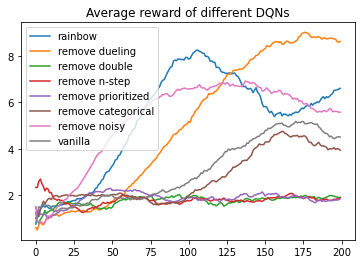

In [27]:
#plot the rewards
plt.plot(avg_rewards, label='rainbow')
plt.plot(avg_rewards1, label='remove dueling')
plt.plot(avg_rewards2, label='remove double')
plt.plot(avg_rewards3, label='remove n-step')
plt.plot(avg_rewards4, label='remove prioritized')
plt.plot(avg_rewards5, label='remove categorical')
plt.plot(avg_rewards6, label='remove noisy')
plt.plot(avg_rewards7, label='vanilla')

plt.title('Average reward of different DQNs')
plt.legend()
plt.show()

Based on above, the rainbow DQN beats all the variants except the one removing dueling, i.e. config1. We will try to further tune this config1.

Interestingly, vanilla DQN beats some of the variants, implying that some rainbow elements may harm the performance and we should test before fully tuning the model.

Let's load and print the model structure of config1.

In [29]:
trainer1 = dqn.DQNTrainer(config=config1)
trainer1.restore(checkpoint1)
policy = trainer1.get_policy()
policy.model.value_function()
print(policy.model)

Install gputil for GPU system monitoring.
2022-04-11 18:21:52,464	INFO trainable.py:495 -- Restored on 127.0.0.1 from checkpoint: /Users/suenchihang/ray_results/DQNTrainer_Breakout-v0_2022-04-11_02-56-31n50xulvq/checkpoint_000191/checkpoint-191
2022-04-11 18:21:52,469	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 191, '_timesteps_total': 6112, '_time_total': 5079.276699066162, '_episodes_total': 505}


VisionNetwork_as_DQNTorchModel(
  (_convs): Sequential(
    (0): SlimConv2d(
      (_model): Sequential(
        (0): ZeroPad2d((2, 2, 2, 2))
        (1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
        (2): ReLU()
      )
    )
    (1): SlimConv2d(
      (_model): Sequential(
        (0): ZeroPad2d((1, 2, 1, 2))
        (1): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
        (2): ReLU()
      )
    )
    (2): SlimConv2d(
      (_model): Sequential(
        (0): Conv2d(32, 256, kernel_size=(11, 11), stride=(1, 1))
        (1): ReLU()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (advantage_module): Sequential(
    (dueling_A_0): NoisyLayer(
      (activation): ReLU()
    )
    (A): NoisyLayer()
  )
)


##### Ray Tune

Let's tune by grid search for min and max reward, as I am not sure whether DeepMind default clipping value at 1 or the Ray default clipping value at 10 would be better. Also let's tune the learning rate around default 0.0005. We have in tota1 5 x 2 x 2 = 20 trials to run.

In [36]:
#Ref: https://www.anyscale.com/blog/an-introduction-to-reinforcement-learning-with-openai-gym-rllib-and-google

#initialize for random seeds/states
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
rng = np.random.default_rng(12345)
np.random.seed(42)
tf.random.set_seed(42)

parameter_search_config = {
    "env": "Breakout-v0",
    "framework": "torch",

    # Hyperparameter tuning
    "model": {
      "v_min": ray.tune.grid_search([[-1], [-10]]),
      "v_max": ray.tune.grid_search([[1], [10]]),
    },
    "lr": ray.tune.grid_search([[5e-2],[5e-3],[5e-4],[5e-5],[5e-6]])
}

# To explicitly stop or restart Ray, use the shutdown API.
ray.shutdown()

ray.init(
   num_cpus=4,
  include_dashboard=False,
  ignore_reinit_error=True,
  log_to_driver=False,
)

stop={"training_iteration": 20}

parameter_search_analysis = ray.tune.run(
  "DQN",
  config=parameter_search_config,
  stop=stop,
  num_samples=4,
  metric="episode_reward_mean",
  mode="max",
)

print(
  "Best hyperparameters found:",
  parameter_search_analysis.best_config,
)

Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00000,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00001,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00002,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00003,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00004,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00005,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00006,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00007,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00008,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00009,PENDING,,[5e-06],[10],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00000,RUNNING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00001,RUNNING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00002,RUNNING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00003,RUNNING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00004,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00005,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00006,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00007,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00008,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00009,PENDING,,[5e-06],[10],[-1]


2022-04-11 21:48:21,073	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00003: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43558, ip=127

2022-04-11 21:48:21,091	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00002: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43556, ip=127

Result for DQN_Breakout-v0_b51cf_00003:
  trial_id: b51cf_00003
  
Result for DQN_Breakout-v0_b51cf_00001:
  trial_id: b51cf_00001
  
Result for DQN_Breakout-v0_b51cf_00000:
  trial_id: b51cf_00000
  
Result for DQN_Breakout-v0_b51cf_00002:
  trial_id: b51cf_00002
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00004,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00005,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00006,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00007,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00008,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00009,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00010,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00011,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00012,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00013,PENDING,,[5e-05],[1],[-10]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00004,RUNNING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00005,RUNNING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00006,RUNNING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00007,RUNNING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00008,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00009,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00010,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00011,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00012,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00013,PENDING,,[5e-05],[1],[-10]


2022-04-11 21:48:33,876	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00005: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43578, ip=127

2022-04-11 21:48:33,893	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00007: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43579, ip=127

Result for DQN_Breakout-v0_b51cf_00005:
  trial_id: b51cf_00005
  
Result for DQN_Breakout-v0_b51cf_00004:
  trial_id: b51cf_00004
  
Result for DQN_Breakout-v0_b51cf_00006:
  trial_id: b51cf_00006
  
Result for DQN_Breakout-v0_b51cf_00007:
  trial_id: b51cf_00007
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00008,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00009,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00010,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00011,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00012,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00013,PENDING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00014,PENDING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00015,PENDING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00016,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00017,PENDING,,[0.0005],[10],[-10]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00008,RUNNING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00009,RUNNING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00010,RUNNING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00011,RUNNING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00012,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00013,PENDING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00014,PENDING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00015,PENDING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00016,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00017,PENDING,,[0.0005],[10],[-10]


2022-04-11 21:48:43,358	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00011: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43589, ip=127

2022-04-11 21:48:43,378	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00010: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43587, ip=127

Result for DQN_Breakout-v0_b51cf_00011:
  trial_id: b51cf_00011
  
Result for DQN_Breakout-v0_b51cf_00008:
  trial_id: b51cf_00008
  
Result for DQN_Breakout-v0_b51cf_00009:
  trial_id: b51cf_00009
  
Result for DQN_Breakout-v0_b51cf_00010:
  trial_id: b51cf_00010
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00012,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00013,PENDING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00014,PENDING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00015,PENDING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00016,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00017,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00018,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00019,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00020,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00021,PENDING,,[0.005],[1],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00012,RUNNING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00013,RUNNING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00014,RUNNING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00015,RUNNING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00016,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00017,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00018,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00019,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00020,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00021,PENDING,,[0.005],[1],[-1]


2022-04-11 21:48:52,575	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00015: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43599, ip=127

2022-04-11 21:48:52,591	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00014: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43598, ip=127

Result for DQN_Breakout-v0_b51cf_00015:
  trial_id: b51cf_00015
  
Result for DQN_Breakout-v0_b51cf_00012:
  trial_id: b51cf_00012
  
Result for DQN_Breakout-v0_b51cf_00013:
  trial_id: b51cf_00013
  
Result for DQN_Breakout-v0_b51cf_00014:
  trial_id: b51cf_00014
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00016,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00017,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00018,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00019,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00020,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00021,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00022,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00023,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00024,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00025,PENDING,,[0.05],[10],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00016,RUNNING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00017,RUNNING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00018,RUNNING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00019,RUNNING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00020,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00021,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00022,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00023,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00024,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00025,PENDING,,[0.05],[10],[-1]


2022-04-11 21:49:02,090	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00018: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43608, ip=127

2022-04-11 21:49:02,104	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00019: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43607, ip=127

Result for DQN_Breakout-v0_b51cf_00018:
  trial_id: b51cf_00018
  
Result for DQN_Breakout-v0_b51cf_00017:
  trial_id: b51cf_00017
  
Result for DQN_Breakout-v0_b51cf_00016:
  trial_id: b51cf_00016
  
Result for DQN_Breakout-v0_b51cf_00019:
  trial_id: b51cf_00019
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00020,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00021,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00022,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00023,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00024,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00025,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00026,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00027,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00028,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00029,PENDING,,[5e-06],[10],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00020,RUNNING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00021,RUNNING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00022,RUNNING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00023,RUNNING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00024,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00025,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00026,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00027,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00028,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00029,PENDING,,[5e-06],[10],[-1]


2022-04-11 21:49:11,083	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00021: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43614, ip=127

2022-04-11 21:49:11,115	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00022: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43615, ip=127

Result for DQN_Breakout-v0_b51cf_00021:
  trial_id: b51cf_00021
  
Result for DQN_Breakout-v0_b51cf_00023:
  trial_id: b51cf_00023
  
Result for DQN_Breakout-v0_b51cf_00020:
  trial_id: b51cf_00020
  
Result for DQN_Breakout-v0_b51cf_00022:
  trial_id: b51cf_00022
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00024,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00025,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00026,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00027,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00028,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00029,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00030,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00031,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00032,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00033,PENDING,,[5e-05],[1],[-10]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00024,RUNNING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00025,RUNNING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00026,RUNNING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00027,RUNNING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00028,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00029,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00030,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00031,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00032,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00033,PENDING,,[5e-05],[1],[-10]


2022-04-11 21:49:20,286	WARNING ray_trial_executor.py:655 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.
2022-04-11 21:49:20,287	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00025: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/r

2022-04-11 21:49:20,298	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00026: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43624, ip=127

Result for DQN_Breakout-v0_b51cf_00025:
  trial_id: b51cf_00025
  
Result for DQN_Breakout-v0_b51cf_00024:
  trial_id: b51cf_00024
  
Result for DQN_Breakout-v0_b51cf_00026:
  trial_id: b51cf_00026
  
Result for DQN_Breakout-v0_b51cf_00027:
  trial_id: b51cf_00027
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00028,RUNNING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00029,RUNNING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00030,RUNNING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00031,RUNNING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00032,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00033,PENDING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00034,PENDING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00035,PENDING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00036,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00037,PENDING,,[0.0005],[10],[-10]


2022-04-11 21:49:29,252	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00031: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43636, ip=127

2022-04-11 21:49:29,276	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00029: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43637, ip=127

Result for DQN_Breakout-v0_b51cf_00031:
  trial_id: b51cf_00031
  
Result for DQN_Breakout-v0_b51cf_00028:
  trial_id: b51cf_00028
  
Result for DQN_Breakout-v0_b51cf_00030:
  trial_id: b51cf_00030
  
Result for DQN_Breakout-v0_b51cf_00029:
  trial_id: b51cf_00029
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00032,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00033,PENDING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00034,PENDING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00035,PENDING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00036,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00037,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00038,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00039,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00040,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00041,PENDING,,[0.005],[1],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00032,RUNNING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00033,RUNNING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00034,RUNNING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00035,RUNNING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00036,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00037,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00038,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00039,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00040,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00041,PENDING,,[0.005],[1],[-1]


2022-04-11 21:49:38,213	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00033: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43651, ip=127

2022-04-11 21:49:38,225	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00034: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43648, ip=127

Result for DQN_Breakout-v0_b51cf_00033:
  trial_id: b51cf_00033
  
Result for DQN_Breakout-v0_b51cf_00032:
  trial_id: b51cf_00032
  
Result for DQN_Breakout-v0_b51cf_00035:
  trial_id: b51cf_00035
  
Result for DQN_Breakout-v0_b51cf_00034:
  trial_id: b51cf_00034
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00036,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00037,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00038,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00039,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00040,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00041,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00042,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00043,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00044,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00045,PENDING,,[0.05],[10],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00036,RUNNING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00037,RUNNING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00038,RUNNING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00039,RUNNING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00040,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00041,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00042,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00043,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00044,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00045,PENDING,,[0.05],[10],[-1]


2022-04-11 21:49:47,870	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00036: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43661, ip=127

2022-04-11 21:49:47,884	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00037: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43662, ip=127

Result for DQN_Breakout-v0_b51cf_00036:
  trial_id: b51cf_00036
  
Result for DQN_Breakout-v0_b51cf_00038:
  trial_id: b51cf_00038
  
Result for DQN_Breakout-v0_b51cf_00039:
  trial_id: b51cf_00039
  
Result for DQN_Breakout-v0_b51cf_00037:
  trial_id: b51cf_00037
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00040,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00041,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00042,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00043,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00044,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00045,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00046,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00047,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00048,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00049,PENDING,,[5e-06],[10],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00040,RUNNING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00041,RUNNING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00042,RUNNING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00043,RUNNING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00044,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00045,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00046,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00047,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00048,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00049,PENDING,,[5e-06],[10],[-1]


2022-04-11 21:49:57,260	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00040: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43675, ip=127

2022-04-11 21:49:57,273	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00041: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43674, ip=127

Result for DQN_Breakout-v0_b51cf_00040:
  trial_id: b51cf_00040
  
Result for DQN_Breakout-v0_b51cf_00043:
  trial_id: b51cf_00043
  
Result for DQN_Breakout-v0_b51cf_00042:
  trial_id: b51cf_00042
  
Result for DQN_Breakout-v0_b51cf_00041:
  trial_id: b51cf_00041
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00044,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00045,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00046,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00047,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00048,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00049,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00050,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00051,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00052,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00053,PENDING,,[5e-05],[1],[-10]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00044,RUNNING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00045,RUNNING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00046,RUNNING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00047,RUNNING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00048,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00049,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00050,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00051,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00052,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00053,PENDING,,[5e-05],[1],[-10]


2022-04-11 21:50:06,892	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00044: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43684, ip=127

2022-04-11 21:50:07,015	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00045: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43686, ip=127

Result for DQN_Breakout-v0_b51cf_00044:
  trial_id: b51cf_00044
  
Result for DQN_Breakout-v0_b51cf_00046:
  trial_id: b51cf_00046
  
Result for DQN_Breakout-v0_b51cf_00047:
  trial_id: b51cf_00047
  
Result for DQN_Breakout-v0_b51cf_00045:
  trial_id: b51cf_00045
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00048,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00049,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00050,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00051,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00052,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00053,PENDING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00054,PENDING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00055,PENDING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00056,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00057,PENDING,,[0.0005],[10],[-10]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00048,RUNNING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00049,RUNNING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00050,RUNNING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00051,RUNNING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00052,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00053,PENDING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00054,PENDING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00055,PENDING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00056,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00057,PENDING,,[0.0005],[10],[-10]


2022-04-11 21:50:16,194	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00048: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43697, ip=127

2022-04-11 21:50:16,216	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00051: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43696, ip=127

Result for DQN_Breakout-v0_b51cf_00048:
  trial_id: b51cf_00048
  
Result for DQN_Breakout-v0_b51cf_00050:
  trial_id: b51cf_00050
  
Result for DQN_Breakout-v0_b51cf_00049:
  trial_id: b51cf_00049
  
Result for DQN_Breakout-v0_b51cf_00051:
  trial_id: b51cf_00051
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00052,RUNNING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00053,RUNNING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00054,RUNNING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00055,RUNNING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00056,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00057,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00058,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00059,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00060,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00061,PENDING,,[0.005],[1],[-1]


2022-04-11 21:50:25,186	WARNING ray_trial_executor.py:655 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.
2022-04-11 21:50:25,188	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00052: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/r

2022-04-11 21:50:25,212	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00055: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43709, ip=127

Result for DQN_Breakout-v0_b51cf_00052:
  trial_id: b51cf_00052
  
Result for DQN_Breakout-v0_b51cf_00053:
  trial_id: b51cf_00053
  
Result for DQN_Breakout-v0_b51cf_00055:
  trial_id: b51cf_00055
  
Result for DQN_Breakout-v0_b51cf_00054:
  trial_id: b51cf_00054
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00056,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00057,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00058,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00059,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00060,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00061,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00062,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00063,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00064,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00065,PENDING,,[0.05],[10],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00056,RUNNING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00057,RUNNING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00058,RUNNING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00059,RUNNING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00060,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00061,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00062,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00063,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00064,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00065,PENDING,,[0.05],[10],[-1]


2022-04-11 21:50:34,106	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00057: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43719, ip=127

2022-04-11 21:50:34,123	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00056: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43721, ip=127

Result for DQN_Breakout-v0_b51cf_00057:
  trial_id: b51cf_00057
  
Result for DQN_Breakout-v0_b51cf_00058:
  trial_id: b51cf_00058
  
Result for DQN_Breakout-v0_b51cf_00059:
  trial_id: b51cf_00059
  
Result for DQN_Breakout-v0_b51cf_00056:
  trial_id: b51cf_00056
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00060,PENDING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00061,PENDING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00062,PENDING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00063,PENDING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00064,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00065,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00066,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00067,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00068,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00069,PENDING,,[5e-06],[10],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00060,RUNNING,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00061,RUNNING,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00062,RUNNING,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00063,RUNNING,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00064,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00065,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00066,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00067,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00068,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00069,PENDING,,[5e-06],[10],[-1]


2022-04-11 21:50:44,079	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00062: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43735, ip=127

2022-04-11 21:50:44,098	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00063: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43732, ip=127

Result for DQN_Breakout-v0_b51cf_00062:
  trial_id: b51cf_00062
  
Result for DQN_Breakout-v0_b51cf_00060:
  trial_id: b51cf_00060
  
Result for DQN_Breakout-v0_b51cf_00061:
  trial_id: b51cf_00061
  
Result for DQN_Breakout-v0_b51cf_00063:
  trial_id: b51cf_00063
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00064,PENDING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00065,PENDING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00066,PENDING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00067,PENDING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00068,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00069,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00070,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00071,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00072,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00073,PENDING,,[5e-05],[1],[-10]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00064,RUNNING,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00065,RUNNING,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00066,RUNNING,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00067,RUNNING,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00068,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00069,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00070,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00071,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00072,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00073,PENDING,,[5e-05],[1],[-10]


2022-04-11 21:50:53,789	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00065: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43744, ip=127

2022-04-11 21:50:53,805	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00064: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43742, ip=127

Result for DQN_Breakout-v0_b51cf_00065:
  trial_id: b51cf_00065
  
Result for DQN_Breakout-v0_b51cf_00067:
  trial_id: b51cf_00067
  
Result for DQN_Breakout-v0_b51cf_00066:
  trial_id: b51cf_00066
  
Result for DQN_Breakout-v0_b51cf_00064:
  trial_id: b51cf_00064
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00068,PENDING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00069,PENDING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00070,PENDING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00071,PENDING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00072,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00073,PENDING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00074,PENDING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00075,PENDING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00076,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00077,PENDING,,[0.0005],[10],[-10]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00068,RUNNING,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00069,RUNNING,,[5e-06],[10],[-1]
DQN_Breakout-v0_b51cf_00070,RUNNING,,[0.05],[1],[-10]
DQN_Breakout-v0_b51cf_00071,RUNNING,,[0.005],[1],[-10]
DQN_Breakout-v0_b51cf_00072,PENDING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00073,PENDING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00074,PENDING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00075,PENDING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00076,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00077,PENDING,,[0.0005],[10],[-10]


2022-04-11 21:51:03,394	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00070: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43754, ip=127

2022-04-11 21:51:03,412	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00069: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43753, ip=127

Result for DQN_Breakout-v0_b51cf_00070:
  trial_id: b51cf_00070
  
Result for DQN_Breakout-v0_b51cf_00071:
  trial_id: b51cf_00071
  
Result for DQN_Breakout-v0_b51cf_00068:
  trial_id: b51cf_00068
  
Result for DQN_Breakout-v0_b51cf_00069:
  trial_id: b51cf_00069
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00072,RUNNING,,[0.0005],[1],[-10]
DQN_Breakout-v0_b51cf_00073,RUNNING,,[5e-05],[1],[-10]
DQN_Breakout-v0_b51cf_00074,RUNNING,,[5e-06],[1],[-10]
DQN_Breakout-v0_b51cf_00075,RUNNING,,[0.05],[10],[-10]
DQN_Breakout-v0_b51cf_00076,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00077,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00078,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00079,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00000,ERROR,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00001,ERROR,,[0.005],[1],[-1]


2022-04-11 21:51:12,345	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00075: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43759, ip=127

2022-04-11 21:51:12,367	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00072: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43762, ip=127

Result for DQN_Breakout-v0_b51cf_00075:
  trial_id: b51cf_00075
  
Result for DQN_Breakout-v0_b51cf_00074:
  trial_id: b51cf_00074
  
Result for DQN_Breakout-v0_b51cf_00073:
  trial_id: b51cf_00073
  
Result for DQN_Breakout-v0_b51cf_00072:
  trial_id: b51cf_00072
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00076,PENDING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00077,PENDING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00078,PENDING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00079,PENDING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00000,ERROR,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00001,ERROR,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00002,ERROR,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00003,ERROR,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00004,ERROR,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00005,ERROR,,[0.05],[10],[-1]


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00076,RUNNING,,[0.005],[10],[-10]
DQN_Breakout-v0_b51cf_00077,RUNNING,,[0.0005],[10],[-10]
DQN_Breakout-v0_b51cf_00078,RUNNING,,[5e-05],[10],[-10]
DQN_Breakout-v0_b51cf_00079,RUNNING,,[5e-06],[10],[-10]
DQN_Breakout-v0_b51cf_00000,ERROR,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00001,ERROR,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00002,ERROR,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00003,ERROR,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00004,ERROR,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00005,ERROR,,[0.05],[10],[-1]


2022-04-11 21:51:21,112	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00079: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43768, ip=127

2022-04-11 21:51:21,126	ERROR trial_runner.py:920 -- Trial DQN_Breakout-v0_b51cf_00078: Error processing event.
Traceback (most recent call last):
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/trial_runner.py", line 886, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/tune/ray_trial_executor.py", line 675, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/Users/suenchihang/opt/anaconda3/envs/rosetta_rl/lib/python3.9/site-packages/ray/worker.py", line 1765, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::DQNTrainer.__init__() (pid=43769, ip=127

Result for DQN_Breakout-v0_b51cf_00079:
  trial_id: b51cf_00079
  
Result for DQN_Breakout-v0_b51cf_00077:
  trial_id: b51cf_00077
  
Result for DQN_Breakout-v0_b51cf_00076:
  trial_id: b51cf_00076
  
Result for DQN_Breakout-v0_b51cf_00078:
  trial_id: b51cf_00078
  


Trial name,status,loc,lr,model/v_max,model/v_min
DQN_Breakout-v0_b51cf_00000,ERROR,,[0.05],[1],[-1]
DQN_Breakout-v0_b51cf_00001,ERROR,,[0.005],[1],[-1]
DQN_Breakout-v0_b51cf_00002,ERROR,,[0.0005],[1],[-1]
DQN_Breakout-v0_b51cf_00003,ERROR,,[5e-05],[1],[-1]
DQN_Breakout-v0_b51cf_00004,ERROR,,[5e-06],[1],[-1]
DQN_Breakout-v0_b51cf_00005,ERROR,,[0.05],[10],[-1]
DQN_Breakout-v0_b51cf_00006,ERROR,,[0.005],[10],[-1]
DQN_Breakout-v0_b51cf_00007,ERROR,,[0.0005],[10],[-1]
DQN_Breakout-v0_b51cf_00008,ERROR,,[5e-05],[10],[-1]
DQN_Breakout-v0_b51cf_00009,ERROR,,[5e-06],[10],[-1]


TuneError: ('Trials did not complete', [DQN_Breakout-v0_b51cf_00000, DQN_Breakout-v0_b51cf_00001, DQN_Breakout-v0_b51cf_00002, DQN_Breakout-v0_b51cf_00003, DQN_Breakout-v0_b51cf_00004, DQN_Breakout-v0_b51cf_00005, DQN_Breakout-v0_b51cf_00006, DQN_Breakout-v0_b51cf_00007, DQN_Breakout-v0_b51cf_00008, DQN_Breakout-v0_b51cf_00009, DQN_Breakout-v0_b51cf_00010, DQN_Breakout-v0_b51cf_00011, DQN_Breakout-v0_b51cf_00012, DQN_Breakout-v0_b51cf_00013, DQN_Breakout-v0_b51cf_00014, DQN_Breakout-v0_b51cf_00015, DQN_Breakout-v0_b51cf_00016, DQN_Breakout-v0_b51cf_00017, DQN_Breakout-v0_b51cf_00018, DQN_Breakout-v0_b51cf_00019, DQN_Breakout-v0_b51cf_00020, DQN_Breakout-v0_b51cf_00021, DQN_Breakout-v0_b51cf_00022, DQN_Breakout-v0_b51cf_00023, DQN_Breakout-v0_b51cf_00024, DQN_Breakout-v0_b51cf_00025, DQN_Breakout-v0_b51cf_00026, DQN_Breakout-v0_b51cf_00027, DQN_Breakout-v0_b51cf_00028, DQN_Breakout-v0_b51cf_00029, DQN_Breakout-v0_b51cf_00030, DQN_Breakout-v0_b51cf_00031, DQN_Breakout-v0_b51cf_00032, DQN_Breakout-v0_b51cf_00033, DQN_Breakout-v0_b51cf_00034, DQN_Breakout-v0_b51cf_00035, DQN_Breakout-v0_b51cf_00036, DQN_Breakout-v0_b51cf_00037, DQN_Breakout-v0_b51cf_00038, DQN_Breakout-v0_b51cf_00039, DQN_Breakout-v0_b51cf_00040, DQN_Breakout-v0_b51cf_00041, DQN_Breakout-v0_b51cf_00042, DQN_Breakout-v0_b51cf_00043, DQN_Breakout-v0_b51cf_00044, DQN_Breakout-v0_b51cf_00045, DQN_Breakout-v0_b51cf_00046, DQN_Breakout-v0_b51cf_00047, DQN_Breakout-v0_b51cf_00048, DQN_Breakout-v0_b51cf_00049, DQN_Breakout-v0_b51cf_00050, DQN_Breakout-v0_b51cf_00051, DQN_Breakout-v0_b51cf_00052, DQN_Breakout-v0_b51cf_00053, DQN_Breakout-v0_b51cf_00054, DQN_Breakout-v0_b51cf_00055, DQN_Breakout-v0_b51cf_00056, DQN_Breakout-v0_b51cf_00057, DQN_Breakout-v0_b51cf_00058, DQN_Breakout-v0_b51cf_00059, DQN_Breakout-v0_b51cf_00060, DQN_Breakout-v0_b51cf_00061, DQN_Breakout-v0_b51cf_00062, DQN_Breakout-v0_b51cf_00063, DQN_Breakout-v0_b51cf_00064, DQN_Breakout-v0_b51cf_00065, DQN_Breakout-v0_b51cf_00066, DQN_Breakout-v0_b51cf_00067, DQN_Breakout-v0_b51cf_00068, DQN_Breakout-v0_b51cf_00069, DQN_Breakout-v0_b51cf_00070, DQN_Breakout-v0_b51cf_00071, DQN_Breakout-v0_b51cf_00072, DQN_Breakout-v0_b51cf_00073, DQN_Breakout-v0_b51cf_00074, DQN_Breakout-v0_b51cf_00075, DQN_Breakout-v0_b51cf_00076, DQN_Breakout-v0_b51cf_00077, DQN_Breakout-v0_b51cf_00078, DQN_Breakout-v0_b51cf_00079])

In [ ]:
config_final=config1.copy()
config_final['lr'] = 
config_final['v_min'] = 
config_final['v_max'] = 
config_final['num_workers'] = 4
avg_rewards_final, checkpoint_final = trainDQN(config_final, 1000)

# Bonus task - SAC model

If we have time, we may consider more advanced model - SAC model. Below is sampe code from official website of ray.

In [28]:
#https://docs.ray.io/en/latest/rllib/rllib-models.html
class TorchContActionQModel(TorchModelV2):
    """A simple, q-value-from-cont-action model (for e.g. SAC type algos)."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        nn.Module.__init__(self)
        # Pass num_outputs=None into super constructor (so that no action/
        # logits output layer is built).
        # Alternatively, you can pass in num_outputs=[last layer size of
        # config[model][fcnet_hiddens]] AND set no_last_linear=True, but
        # this seems more tedious as you will have to explain users of this
        # class that num_outputs is NOT the size of your Q-output layer.
        super(TorchContActionQModel, self).__init__(obs_space, action_space,
                                                    None, model_config, name)

        # Now: self.num_outputs contains the last layer's size, which
        # we can use to construct the single q-value computing head.

        # Nest an RLlib FullyConnectedNetwork (torch or tf) into this one here
        # to be used for Q-value calculation.
        # Use the current value of self.num_outputs, which is the wrapped
        # model's output layer size.
        combined_space = Box(-1.0, 1.0,
                             (self.num_outputs + action_space.shape[0], ))
        self.q_head = TorchFullyConnectedNetwork(combined_space, action_space,
                                                 1, model_config, "q_head")

        # Missing here: Probably still have to provide action output layer
        # and value layer and make sure self.num_outputs is correctly set.

    def get_single_q_value(self, underlying_output, action):
        # Calculate the q-value after concating the underlying output with
        # the given action.
        input_ = torch.cat([underlying_output, action], dim=-1)
        # Construct a simple input_dict (needed for self.q_head as it's an
        # RLlib ModelV2).
        input_dict = {"obs": input_}
        # Ignore state outputs.
        q_values, _ = self.q_head(input_dict)
        return q_values

NameError: name 'TorchModelV2' is not defined

In [ ]:
my_cont_action_q_model = ModelCatalog.get_model_v2(
        obs_space=obs_space,
        action_space=action_space,
        num_outputs=2,
        model_config=MODEL_DEFAULTS,
        framework=args.framework,
        # Providing the `model_interface` arg will make the factory
        # wrap the chosen default model with our new model API class
        # (DuelingQModel). This way, both `forward` and `get_q_values`
        # are available in the returned class.
        model_interface=ContActionQModel
        if args.framework != "torch" else TorchContActionQModel,
        name="cont_action_q_model",
    )